In [10]:
# importing packages

import os

import re
import ast
import json
import time

import pandas as pd
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta, date

import twint
import nest_asyncio
nest_asyncio.apply()

In [3]:
# functions that are initially used

def scrapeTweets(coin, date:str, limit=None):
    """Scrapes the tweets across specific period with a specific hashtag"""
    
    df = pd.DataFrame()
    d = datetime.strptime(date[0], '%Y-%m-%d').date()
    while d <= datetime.strptime(date[1], '%Y-%m-%d').date():
        print(f'Scraping the tweets from {d}')
        c = twint.Config(
        Store_object = True,
        Pandas = True,
        Search = coin,
        Lang = 'en',
        Hide_output = True,
        Until = str(d + timedelta(days=1)),
        Since = str(d),
        Limit = limit,
        Pandas_clean = True
        )
        twint.run.Search(c)
        if d == datetime.strptime(date[0], '%Y-%m-%d').date():
            df = twint.storage.panda.Tweets_df
        else:
            df = df.append(twint.storage.panda.Tweets_df, ignore_index=True)
        time.sleep(10) 
        print("BREAK")   
        d += timedelta(days=1)       
    return df

def get_sentiment(df):
    """Calculates (weighted) sentiment scores for each tweet in the sample"""
    
    df = df.iloc[:,1:]
    df = df[df['language']=='en']
    df = df[['date','tweet','urls','hashtags','nlikes','nretweets']]
    df['urls']=list(map(lambda x: ast.literal_eval(x), df['urls']))
    df['cleaned'] = list(map(lambda x: re.sub("@[A-Za-z0-9_]+","", x.replace('#', '')), df['tweet']))
    df['cleaned'] = list(map(lambda x: re.sub(r"http\S+", "", x), df['cleaned']))
    df['weight'] = df['nretweets'] + df['nlikes'] + 1
    Print('Now the sentiment score is being estimated for each tweet in the sample...')
    df.loc[:, 'Sentiment score'] = list(map(
        lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'], df['cleaned']))
    print('Done')
    df.loc[:,'Weighted Sentiment score'] = df['Sentiment score'] * df['weight']
    return(df)

# adding dictionary of words related to specific cryptos to deteermine them in tweets
crypto_words = {
    
    'bitcoin': ['bitcoin', 'btc', 'BITCOIN', 'BTC','Bitcoin'],
    'ethereum': ['ETH','ether', 'ETHER','eth','ethereum','ETHEREUM','Ethereum'],
    'dogecoin': ['DOGE','doge', 'DOGECOIN','dogecoin','Dogecoin'],
    'litecoin': ['litecoin', 'ltc', 'LITECOIN', 'LTC','Litecoin'],
    'ripple': ['ripple', 'xrp', 'RIPPLE', 'XRP','Ripple'],
    'dash': ['dash', 'DASH', 'Dash'],
    'monero': ['monero', 'MONERO', 'Monero', 'XMR', 'xmr'],
    'safemoon': ['safemoon','SAFEMOON','SafeMoon','Safemoon'],
    'cumrocket': ['cumrocket','Cumrocket','CUMROCKET','CUMMIES','cummies'],
    'stellarlumens':['Stellar Lumens','stellarlumens', 'XLM', 'xlm', 'Stellar', 'stellar', 'STELLAR'],
    'uniswap':['uniswap','Uniswap','UNISWAP'],
    'sushiswap':['sushiswap','Sushiswap','SUSHISWAP','sushi swap','Sushi swap'],
    'other':['cardano','ada','polkadot']
}

def clean(df, coin, urls, other_coins, ads):
    """Removes tweets specific words and URLS
    
    urls, other_coins, ads - Boolean (tweets are removed when True)
    """
    
    df_2 = df.copy()

    orig_num = len(df_2)
    nec_values = [crypto_words[k] for k in set(list(crypto_words.keys())) - set([coin])]
    spec_list = [item for sublist in nec_values for item in sublist]
    other_coins_num = len(df_2[df_2.cleaned.str.contains('|'.join(spec_list))]) 
    df_2['len_urls']=list(map(lambda x: len(x), df_2['urls']))
    urls_num = len(df_2[df_2['len_urls']!=0]) 
    ads_num = len(df_2[df_2.cleaned.str.contains('|'.join(ad_words))]) 
    
    
    if urls:
        print(f"{urls_num} out of {orig_num} tweets contain URLs")
        df_2 = df_2[df_2['len_urls']==0]

    if other_coins:
        print(f"{other_coins_num} out of {orig_num} tweets mention other coins")
        df_2 = df_2[~df_2.cleaned.str.contains('|'.join(spec_list))]
        
    if ads:
        print(f"{ads_num} out of {orig_num} tweets contain  words common for ads")
        df_2 = df_2[~df_2.cleaned.str.contains('|'.join(ad_words))]
    
    return(df_2)

def format_dates(df):
    """Creates appropriate format of the dates"""
    
    df['dateformat'] = list(map(lambda x: np.where(str(x).endswith('M'),1,0), df['date']))
    df.loc[df['dateformat'] == 0, 'date'] = list(map(lambda x: datetime.strptime(
            str(x), '%Y-%m-%d %H:%M:%S'), df.loc[df['dateformat'] == 0, 'date']))
    df.loc[df['dateformat'] == 1, 'date'] = list(map(lambda x: datetime.strptime(
        str(x), '%Y-%m-%d %I-%p'), df.loc[df['dateformat'] == 1, 'date']))
    df['date'] = list(map(lambda x: datetime.strptime(
            str(x), '%Y-%m-%d %H:%M:%S'), df['date']))
    df['date_only'] = list(map(lambda x: x.date(), df['date']))
    
    df['hour'] = list(map(lambda x: x.hour, df['date']))
    df['datehour'] = list(zip(df['date_only'], df['hour']))
    
    return df

def fetch_prices(ticker, resolution, period):
    """Gets prices from Binance API and puts them into df"""
    
    if resolution=='hour':
        klines = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1HOUR, period[0], period[1])
    if resolution=='minute':
        klines = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1MINUTE, period[0], period[1])
    prices = pd.DataFrame(klines)
    prices.columns = ['open_time',
              'o', 'h', 'l', 'c', 'v',
              'close_time', 'qav', 'num_trades',
              'taker_base_vol', 'taker_quote_vol', 'ignore']
    prices.index = [datetime.fromtimestamp(x/1000.0) for x in prices.open_time]
    prices.reset_index(inplace=True)
    prices.rename(columns={'index':'date','c':'close'}, inplace=True)
    prices['close'] = pd.to_numeric(prices['close'], downcast="float")
    
    return prices 

def aggregate_and_get_prices(df_sentiment, df_prices, df_prices_minutes, resolution='hour'):
    """Aggregate values of sentiment on different labels with correspondence to attached price values"""
    
    format_dates(df_prices)
    format_dates(df_prices_minutes)
    
    
    df_sentiment['date'] = list(map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'), df_sentiment['date']))
    df_sentiment['date_only'] = list(map(lambda x: x.date(), df_sentiment['date']))
    
    
    if resolution=='hour':
        
        time = 'datehour'
        
        volatility = df_prices_minutes.groupby(by=[time]).std().reset_index()[[time,'close']]
        volatility.rename(columns={'close':'Price volatility'}, inplace=True)
        df_prices = df_prices.merge(volatility[[time,'Price volatility']], how='left', on=time)                                                                      
        
        df_sentiment['hour'] = list(map(lambda x: x.hour, df_sentiment['date']))
        df_sentiment[time] = list(zip(df_sentiment['date_only'], df_sentiment['hour']))   
        
        
    if resolution=='minute':  
        
        time = 'dateminute'                                                                        
                                                                                      
        df_prices['minute_of_day'] = list(map(lambda x: x.hour*60 + x.minute, df_prices['date']))
        df_prices[time] = list(zip(df_prices['date_only'], df_prices['minute_of_day']))
        
        df_sentiment['minute_of_day'] = list(map(lambda x: x.hour*60 + x.minute, df_sentiment['date']))
        df_sentiment[time] = list(zip(df_sentiment['date_only'], df_sentiment['minute_of_day']))
    
    if resolution=='day':  
        
        time = 'date_only'     
                                                                              
        df_prices = df_prices[df_prices.hour==23]
        volatility = df_prices_minutes.groupby(by=[time]).std().reset_index()[[time,'close']]
        volatility.rename(columns={'close':'Price volatility'}, inplace=True)
        df_prices = df_prices.merge(volatility[[time,'Price volatility']], how='left', on=time) 
                                                                                                                                                                         
        
    df_sentiment_group = df_sentiment.groupby(by=[time]).mean().reset_index()[[
        time,'Sentiment score']]
    df_sentiment_group[['Weighted Sentiment score']] = df_sentiment.groupby(by=[time]).sum().reset_index()[
        'Weighted Sentiment score']/df_sentiment.groupby(by=[time]).sum().reset_index()['weight']
    
    if resolution=='minute':
        df_sentiment_group = df_sentiment_group.merge(df_prices[[time,'close']], how='left', on=time)
    else:
        df_sentiment_group = df_sentiment_group.merge(df_prices[[time,'close','Price volatility']], how='left', on=time)
    df_sentiment_group.rename(columns={'close':'Cryptocurrency price in USD'}, inplace=True)
    df_sentiment_group['Number of tweets'] = df_sentiment.groupby(by=[time]).count().reset_index()['Sentiment score']
    df_sentiment_group_neu = df_sentiment[
        df_sentiment['Sentiment score']==0].groupby(by=[time]).count().reset_index()[[time,'Sentiment score']]
    df_sentiment_group_neu.rename(columns={'Sentiment score':'Number of tweets with no sentiment'}, inplace=True)
    df_sentiment_group = df_sentiment_group.merge(
        df_sentiment_group_neu[[time,'Number of tweets with no sentiment']], how='left', on=time)
    df_sentiment_group['Share of neutral sentiment'] = df_sentiment_group[
        'Number of tweets with no sentiment']/df_sentiment_group['Number of tweets']
    df_sentiment_group['Cryptocurrency return'] = (
    df_sentiment_group['Cryptocurrency price in USD'] - df_sentiment_group[
        'Cryptocurrency price in USD'].shift())/df_sentiment_group['Cryptocurrency price in USD'].shift()
    if resolution=='hour':
        df_sentiment_group['datetime'] = list(map(lambda x: datetime(
            x[0].year, x[0].month, x[0].day,  x[1]), df_sentiment_group['datehour']))
      
    return(df_sentiment_group)
 

def crosscorr(x,y,lags):
    """Calculates cross-correlation for the set of lags"""
    
    corrs=[]
    for l in lags:
        if l < 0:
            corr=np.corrcoef(x[:l],y[-l:])[0][1]
        elif l==0:
            corr=np.corrcoef(x,y)[0][1]
        else:
            corr=np.corrcoef(x[l:],y[:-l])[0][1]
        corrs.append(corr)
    corrs = pd.Series(corrs) 
    corrs.index = lags
    return pd.Series(corrs)

## 1. Analysis of Bitcoin tweet sentiment and performance

### 1.1. Scraping tweets and estimating sentiment scores

Below is the demonstration of how the data was scraped and processed. Each of the cells can be run separately if there is a need to repeat any step (tweet scraping, sentiment estimation, price fetching, aggregation). There are also already scraped and already processed data available via the link https://drive.google.com/drive/folders/1z-nmjEZJMfgC4r6-Gbf5YQrzadVJ4vm2?usp=sharing. Files shoud be added to working directory.

In [6]:
# scrape tweets

answer = input("Rescrape the tweets? (Y/N): ")
if answer == 'Y':
    bitcoin = scrapeTweets(coin='#bitcoin', date=('2021-02-28', '2021-03-31'))
elif answer == 'N':
    bitcoin = pd.read_csv('btc.csv', parse_dates=['date'], infer_datetime_format=True)
    bitcoin['urls'] = list(map(lambda x: ast.literal_eval(x), bitcoin['urls']))
else:
    print('Please rerun the cell and type either \'Y\' or \'N\'')

Rescrape the tweets? (Y/N): N


C:\Users\Makar\anaconda3\envs\deda\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# calculate the sentiment

answer = input("Recalculate the sentiment scores? (Y/N): ")
if answer == 'Y':
    bitcoin_sent = get_sentiment(bitcoin)
elif answer == 'N':
    bitcoin_sent = pd.read_csv('btc_sentiment.csv')
    bitcoin_sent['urls'] = list(map(lambda x: ast.literal_eval(x), bitcoin_sent['urls']))
else:
    print('Please rerun the cell and type either \'Y\' or \'N\'')

Recalculate the sentiment scores? (Y/N): N


### 1.2. Fetching the prices

In [8]:
# fetch the prices

answer = input("Refetch the cryptocurrency prices? (Y/N): ")
if answer == 'Y':
    from binance.client import Client
    api_key = os.environ.get('binance_api')
    api_secret = os.environ.get('binance_secret')
    client = Client(api_key, api_secret)
    bitcoin_prices_minute = fetch_prices(
        ticker="BTCUSDT", resolution='minute', period = ("28 Feb, 2021", "31 Mar, 2021")
    )
    bitcoin_prices = fetch_prices(
        ticker="BTCUSDT", resolution='hour', period = ("28 Feb, 2021", "31 Mar, 2021")
    )
elif answer == 'N':
    bitcoin_prices_minute = pd.read_csv('bitcoin_prices_minute.csv')
    bitcoin_prices = pd.read_csv('bitcoin_prices.csv')
else:
    print('Please rerun the cell and type either \'Y\' or \'N\'')

Refetch the cryptocurrency prices? (Y/N): N


### 1.3. Visualizaing and examining raw values

In [53]:
# aggregation of the data on hourly and daily level

bitcoin_hour_raw = aggregate_and_get_prices(df_sentiment = bitcoin_sent,
                                                df_prices = bitcoin_prices, 
                                                df_prices_minutes = bitcoin_prices_minute, 
                                                resolution='hour')
bitcoin_day_raw = aggregate_and_get_prices(df_sentiment = bitcoin_sent,
                                                df_prices = bitcoin_prices, 
                                                df_prices_minutes = bitcoin_prices_minute, 
                                                resolution='day')

In [54]:
bitcoin_hour_raw

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
0,"(2021-02-28, 3)",0.220199,-0.158416,44629.17,332.872353,815,277,0.339877,NaN,2021-02-28 03:00:00
1,"(2021-02-28, 4)",0.265879,0.264754,44384.14,157.596332,686,183,0.266764,-0.005490,2021-02-28 04:00:00
2,"(2021-02-28, 5)",0.251434,0.475527,44791.27,223.907857,625,169,0.270400,0.009173,2021-02-28 05:00:00
3,"(2021-02-28, 6)",0.210801,0.254635,44372.43,271.669325,728,228,0.313187,-0.009351,2021-02-28 06:00:00
4,"(2021-02-28, 7)",0.189049,0.010565,44400.83,147.896754,818,248,0.303178,0.000640,2021-02-28 07:00:00
...,...,...,...,...,...,...,...,...,...,...
739,"(2021-03-30, 22)",0.246189,0.335416,58682.41,69.653193,2384,1040,0.436242,-0.000689,2021-03-30 22:00:00
740,"(2021-03-30, 23)",0.251290,0.292903,58746.57,53.096984,1847,747,0.404440,0.001093,2021-03-30 23:00:00
741,"(2021-03-31, 0)",0.254654,0.364389,58991.52,82.563009,1598,651,0.407384,0.004170,2021-03-31 00:00:00
742,"(2021-03-31, 1)",0.240768,0.238302,58885.76,40.465800,1504,599,0.398271,-0.001793,2021-03-31 01:00:00


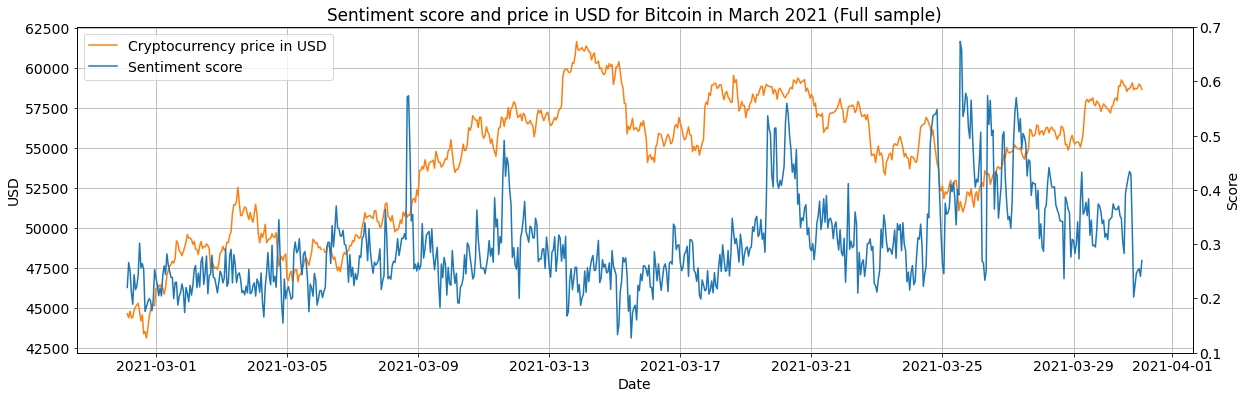

In [11]:
# plotting

import matplotlib.pyplot as plt

plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour_raw['datetime'], bitcoin_hour_raw['Cryptocurrency price in USD'], color='tab:orange', label='Cryptocurrency price in USD')
lns2 = ax2.plot(bitcoin_hour_raw['datetime'], bitcoin_hour_raw['Sentiment score'], color='tab:blue', label='Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Sentiment score and price in USD for Bitcoin in March 2021 (Full sample)')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc='upper left')

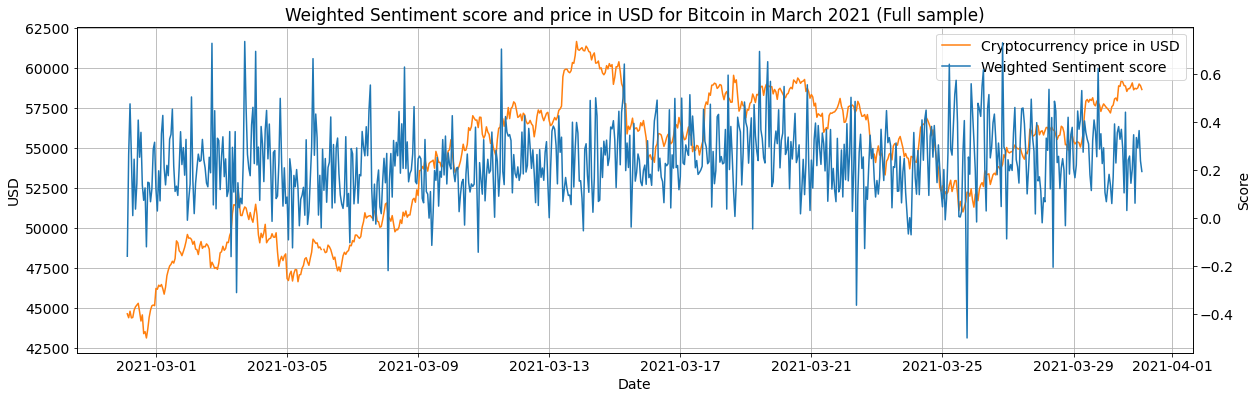

In [55]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour_raw['datetime'], bitcoin_hour_raw['Cryptocurrency price in USD'], 
               color='tab:orange', label='Cryptocurrency price in USD')
lns2 = ax2.plot(bitcoin_hour_raw['datetime'], bitcoin_hour_raw['Weighted Sentiment score'], 
                color='tab:blue', label='Weighted Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Weighted Sentiment score and price in USD for Bitcoin in March 2021 (Full sample)')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc=0)

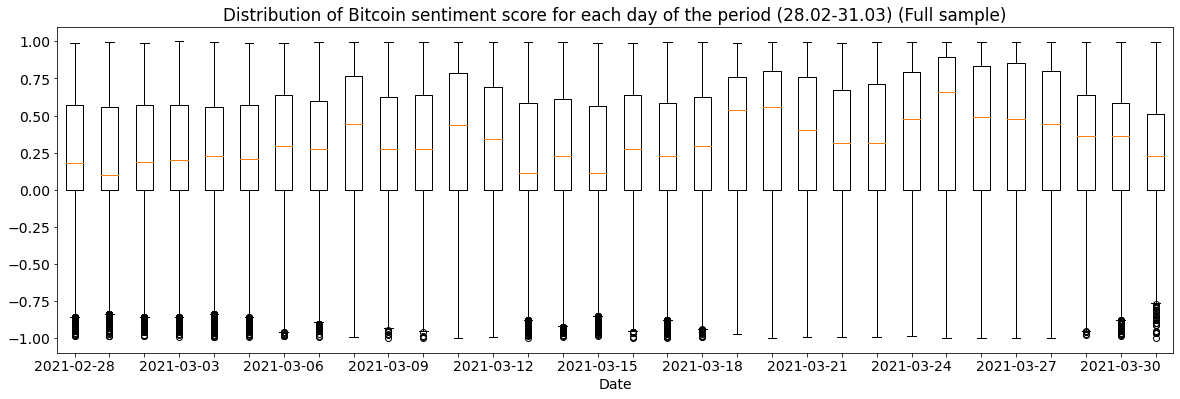

In [14]:
# boxplots for each day

plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))
ax.boxplot([
    bitcoin_sent.loc[bitcoin_sent['date_only'] == item, 'Sentiment score'] for item in sorted(
        list(bitcoin_sent.date_only.unique()))])
ax.set(xticklabels=sorted(
        list(bitcoin_sent.date_only.unique())), xlabel='Date')

for i, label in enumerate(ax.get_xticklabels()):
    if i%3 != 0:
        label.set_visible(False)
        
ax.set_title('Distribution of Bitcoin sentiment score for each day of the period (28.02-31.03) (Full sample)')

#### Wordcloud

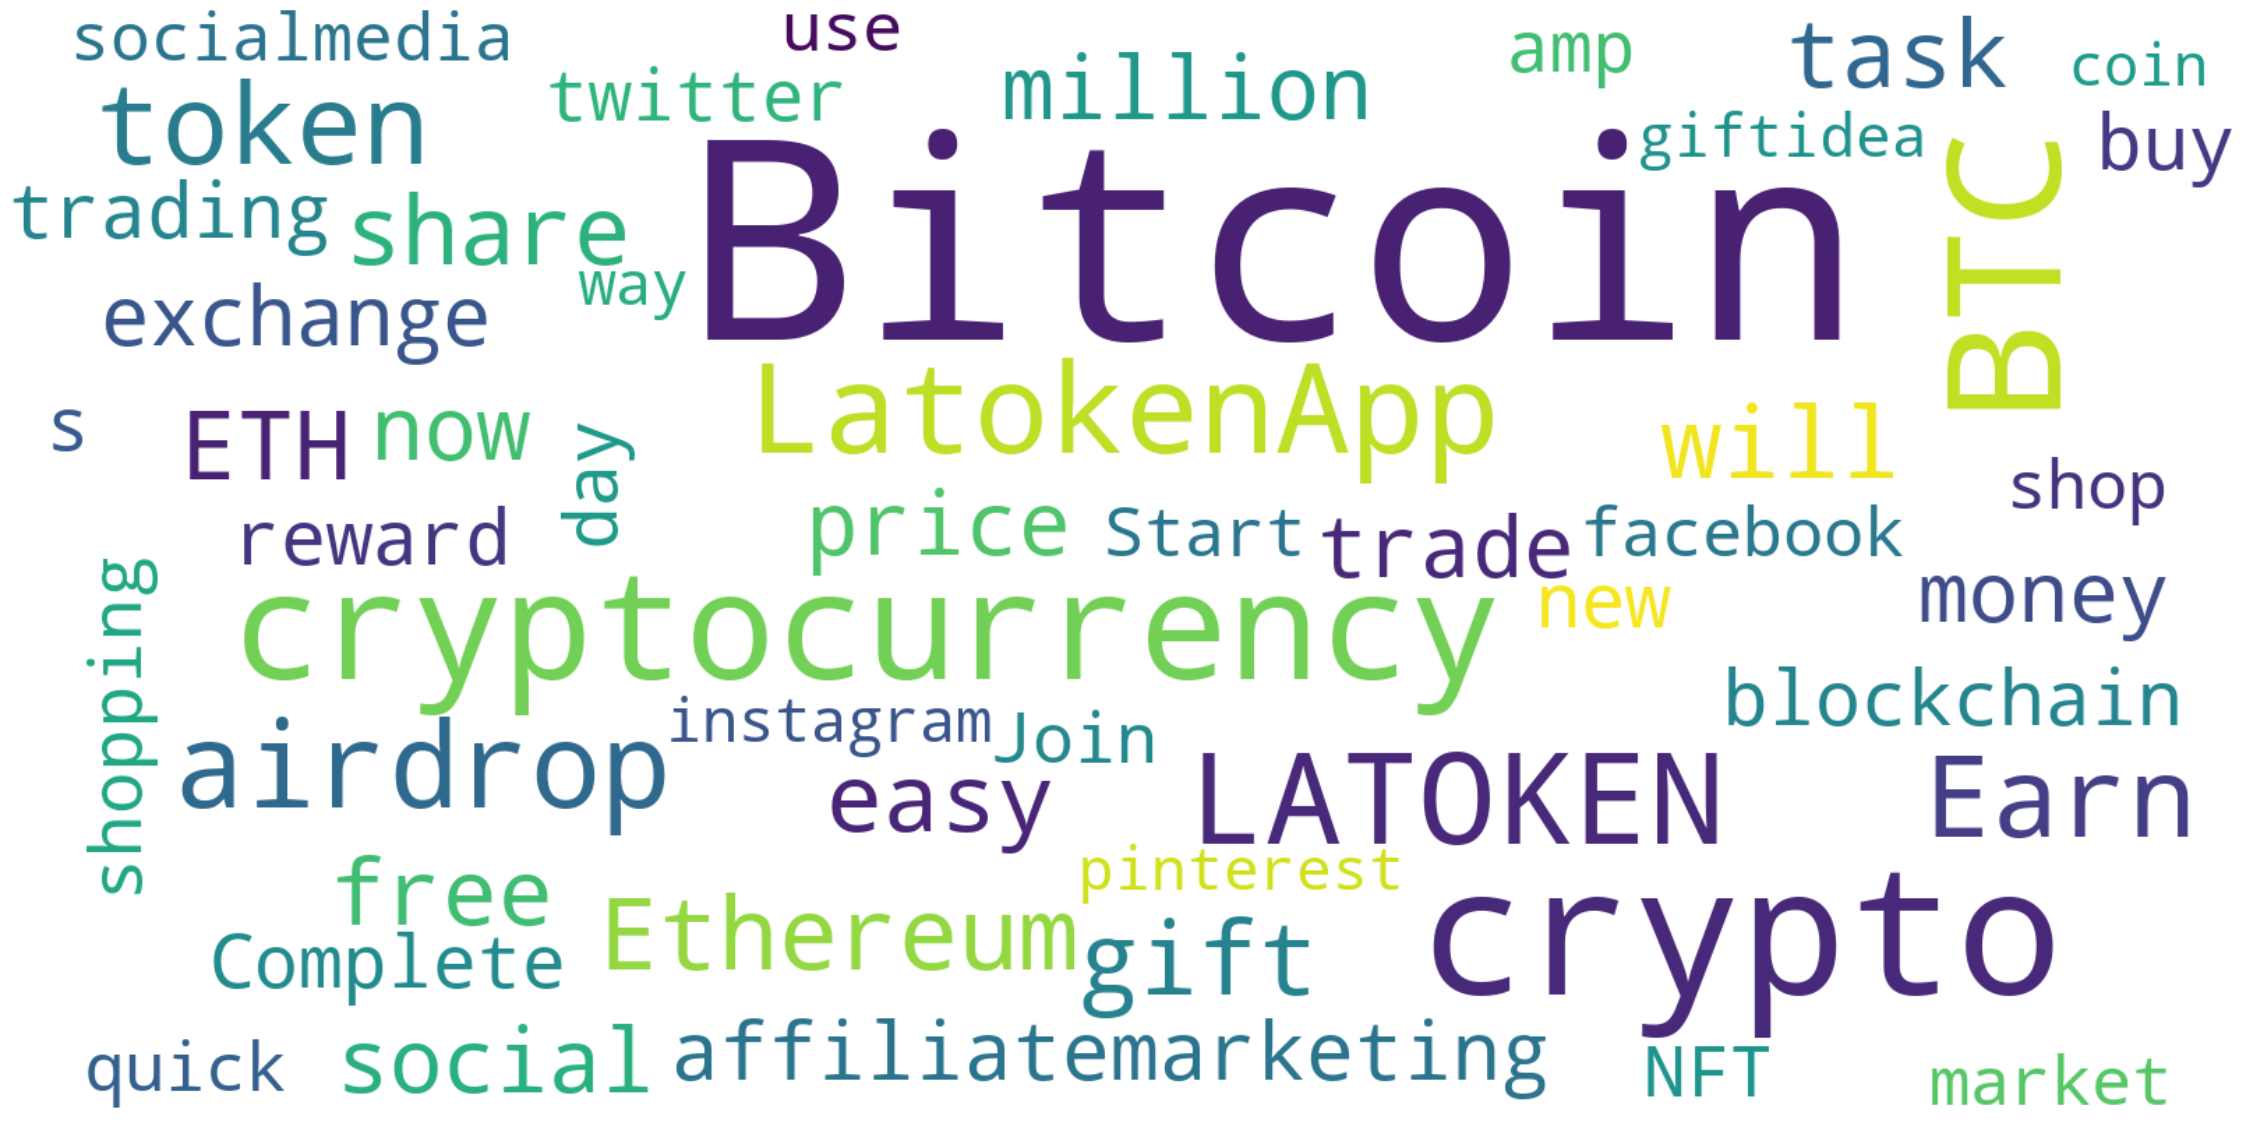

In [15]:
string = pd.Series(bitcoin_sent['cleaned']).str.cat(sep=' ')
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
# stopwords.update(["elonmusk","elon musk","elon","musk","spacex"]) #adding our own stopwords if needed
wordcloud = WordCloud(
    width=1600, stopwords=stopwords,height=800,
    max_font_size=200,max_words=50,collocations=False, 
    background_color='white').generate(string)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
# list of ad-related words that are common in tweets

ad_words = ['LATOKEN', 'LatokenApp', 'shop', 'shopping','airdrop','join','win','free', 'Win', 'Airdrop']

### 1.4. Removing advertisements, URL links, and mentions of other coins

In [30]:
# cleaning bitcoin data from ads

bitcoin_cleaned = clean(bitcoin_sent, coin='bitcoin', urls=True, other_coins=True, ads=True)

431290 out of 877706 tweets contain URLs
182267 out of 877706 tweets mention other coins
261954 out of 877706 tweets contain  words common for ads


In [52]:
# aggregation of the cleaned data

bitcoin_hour = aggregate_and_get_prices(df_sentiment = bitcoin_cleaned,
                                                df_prices = bitcoin_prices, 
                                                df_prices_minutes = bitcoin_prices_minute, 
                                                resolution='hour')
bitcoin_day = aggregate_and_get_prices(df_sentiment = bitcoin_cleaned,
                                                df_prices = bitcoin_prices, 
                                                df_prices_minutes = bitcoin_prices_minute, 
                                                resolution='day')

### 1.5. Visualizing and examining the cleaned data

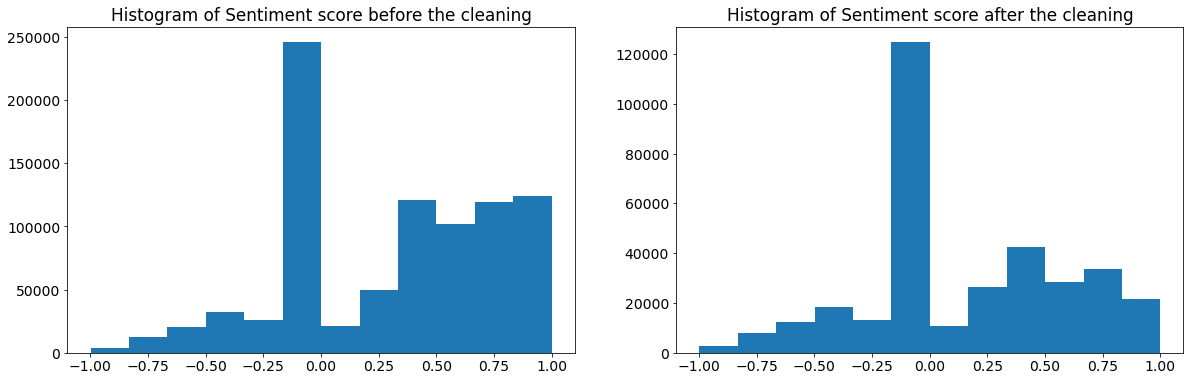

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(bitcoin_sent['Sentiment score'], bins=12)
axs[1].hist(bitcoin_cleaned['Sentiment score'], bins=12)
axs[0].set_title('Histogram of Sentiment score before the cleaning')
axs[1].set_title('Histogram of Sentiment score after the cleaning')

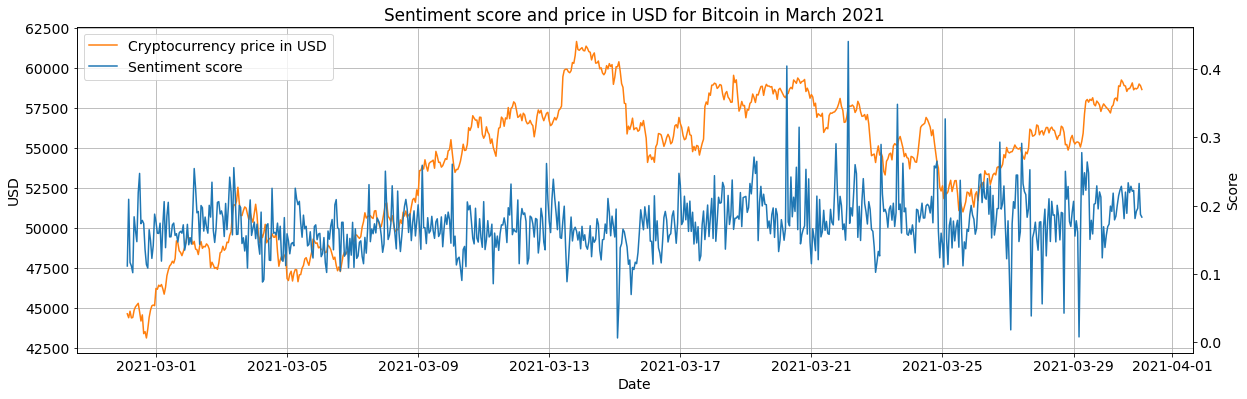

In [56]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour['datetime'], bitcoin_hour['Cryptocurrency price in USD'], color='tab:orange', label='Cryptocurrency price in USD')
lns2 = ax2.plot(bitcoin_hour['datetime'], bitcoin_hour['Sentiment score'], color='tab:blue', label='Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Sentiment score and price in USD for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc='upper left')

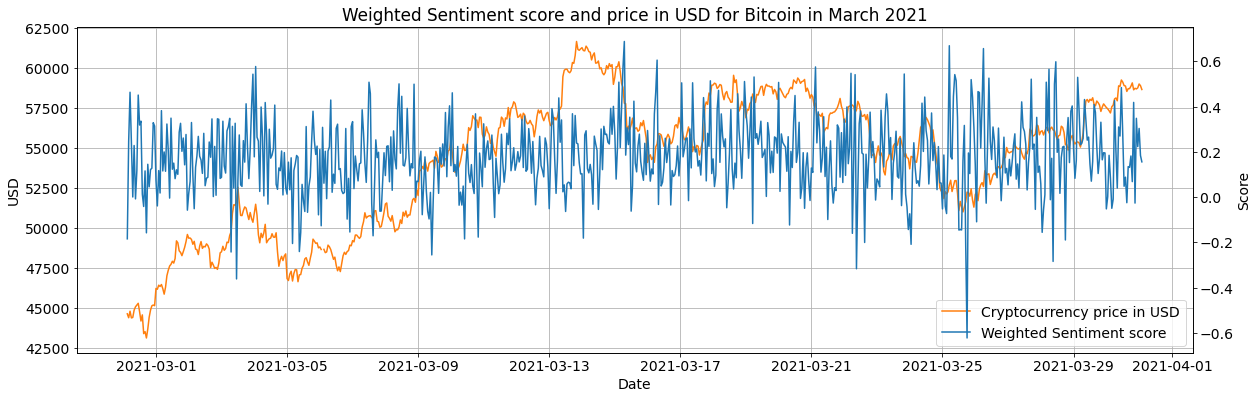

In [65]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour['datetime'], bitcoin_hour['Cryptocurrency price in USD'], color='tab:orange', label='Cryptocurrency price in USD')
lns2 = ax2.plot(bitcoin_hour['datetime'], bitcoin_hour['Weighted Sentiment score'], color='tab:blue', label='Weighted Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Weighted Sentiment score and price in USD for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc='lower right')

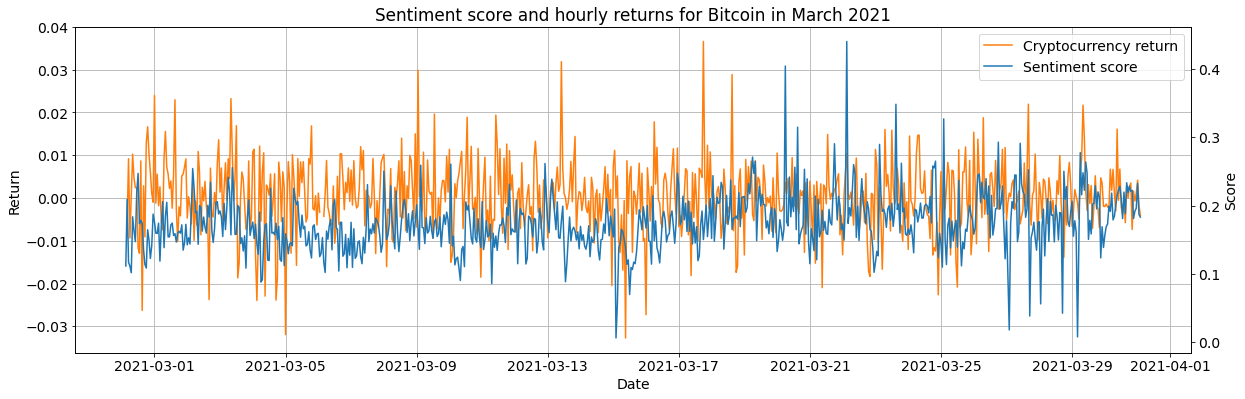

In [61]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour['datetime'], bitcoin_hour['Cryptocurrency return'], color='tab:orange', label='Cryptocurrency return')
lns2 = ax2.plot(bitcoin_hour['datetime'], bitcoin_hour['Sentiment score'], color='tab:blue', label='Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Sentiment score and hourly returns for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc=0)

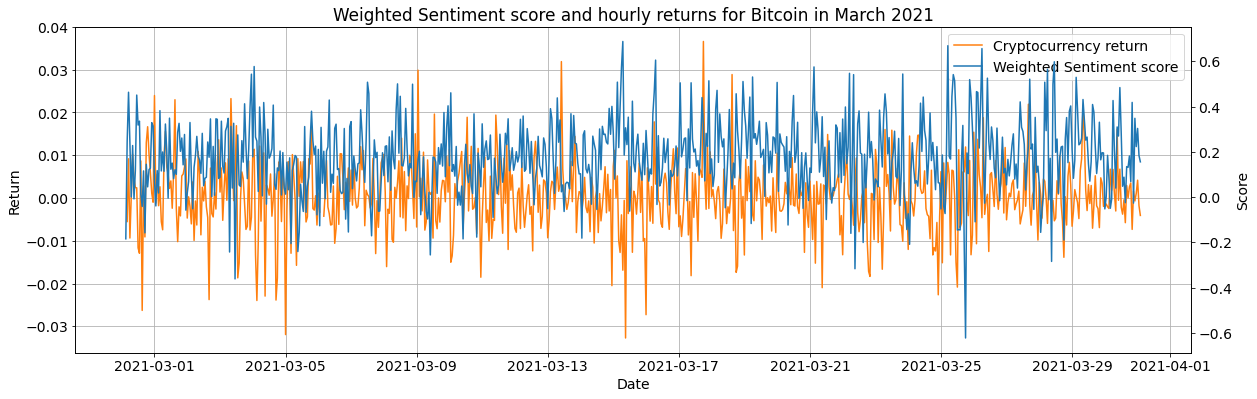

In [62]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour['datetime'], bitcoin_hour['Cryptocurrency return'], color='tab:orange', label='Cryptocurrency return')
lns2 = ax2.plot(bitcoin_hour['datetime'], bitcoin_hour['Weighted Sentiment score'], color='tab:blue', label='Weighted Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Weighted Sentiment score and hourly returns for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc=0)

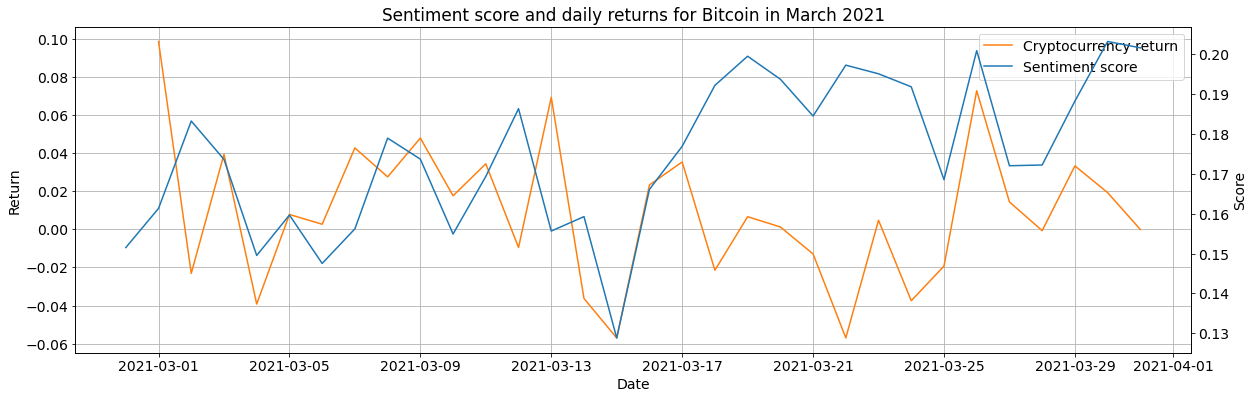

In [63]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_day['date_only'], bitcoin_day['Cryptocurrency return'], color='tab:orange', label='Cryptocurrency return')
lns2 = ax2.plot(bitcoin_day['date_only'], bitcoin_day['Sentiment score'], color='tab:blue', label='Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Sentiment score and daily returns for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc=0)

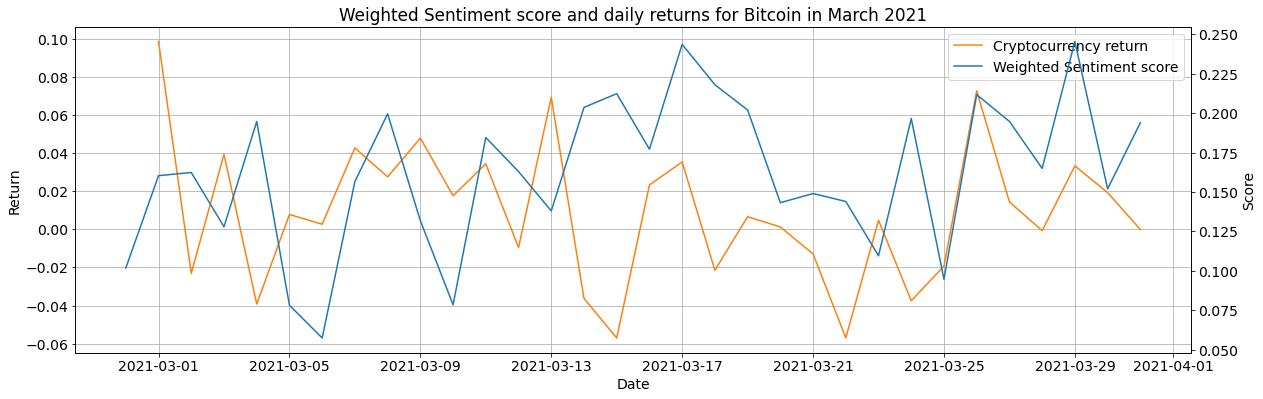

In [64]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_day['date_only'], bitcoin_day['Cryptocurrency return'], color='tab:orange', label='Cryptocurrency return')
lns2 = ax2.plot(bitcoin_day['date_only'], bitcoin_day['Weighted Sentiment score'], color='tab:blue', label='Weighted Sentiment score')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Weighted Sentiment score and daily returns for Bitcoin in March 2021')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax2.set_ylabel('Score')
ax.grid(True)
ax.legend(lns, labs, loc=0)

## 2. Estimating sentiment, fetching prices and aggregating values

In [4]:
dict_coins = {
    'ether': {
        'hashtag': '#ethereum',
        'ticker': 'ETHUSDT',
        'coin': 'ethereum'
    },
    'doge': {
        'hashtag': '#dogecoin',
        'ticker': 'DOGEUSDT',
        'coin': 'dogecoin'
    },
    'stellar': {
        'hashtag': '#xlm',
        'ticker': 'XMRUSDT',
        'coin': 'stellarlumens'
    },
    'uniswap': {
        'hashtag': '#uniswap',
        'ticker': 'UNIUSDT',
        'coin': 'uniswap'
    },
    'sushiswap': {
        'hashtag': '#sushiswap',
        'ticker': 'SUSHIUSDT',
        'coin': 'sushiswap'
    },
        
}

In [5]:
from binance.client import Client
api_key = os.environ.get('binance_api')
api_secret = os.environ.get('binance_secret')
client = Client(api_key, api_secret)

In [86]:
def get_dataframes(coin):
    """Puts together operations to fetch and process data and obtain aggregated sentiment and prices"""

    answer = input("Rescrape the tweets? (Y/N): ")
    if answer == 'Y':
        df = scrapeTweets(coin=dict_coins[coin]['hashtag'], date=('2021-02-28', '2021-03-31'))
    elif answer == 'N':
        df = pd.read_csv(coin+'.csv', lineterminator='\n', parse_dates=['date'], infer_datetime_format=True)
        df['urls'] = list(map(lambda x: ast.literal_eval(x), df['urls']))
    else:
        print('Please rerun the cell and type either \'Y\' or \'N\'')

    answer = input("Recalculate the sentiment scores? (Y/N): ")
    if answer == 'Y':
        coin_sent = get_sentiment(df)
    elif answer == 'N':
        coin_sent = pd.read_csv(coin+'_sentiment.csv')
        coin_sent['urls'] = list(map(lambda x: ast.literal_eval(x), coin_sent['urls']))
    else:
        print('Please rerun the cell and type either \'Y\' or \'N\'')


    answer = input("Refetch the cryptocurrency prices? (Y/N): ")
    if answer == 'Y':
        coin_prices_minute = fetch_prices(
            ticker=dict_coins[coin]['ticker'], resolution='minute', period = ("28 Feb, 2021", "31 Mar, 2021")
        )
        coin_prices = fetch_prices(
            ticker=dict_coins[coin]['ticker'], resolution='hour', period = ("28 Feb, 2021", "31 Mar, 2021")
        )
    elif answer == 'N':
        coin_prices_minute = pd.read_csv(coin+'_prices_minute.csv')
        coin_prices = pd.read_csv(coin+'_prices.csv')
    else:
        print('Please rerun the cell and type either \'Y\' or \'N\'')

    coin_cleaned = clean(coin_sent, coin=dict_coins[coin]['coin'], urls=True, other_coins=True, ads=True)

    coin_hour = aggregate_and_get_prices(df_sentiment = coin_cleaned,
                                                    df_prices = coin_prices, 
                                                    df_prices_minutes = coin_prices_minute, 
                                                    resolution='hour')

    coin_day = aggregate_and_get_prices(df_sentiment = coin_cleaned,
                                                    df_prices = coin_prices, 
                                                    df_prices_minutes = coin_prices_minute, 
                                                    resolution='day')

    return(coin_sent, coin_cleaned, coin_hour, coin_day)

Below the sentiment and prices are obtained for 5 different altcoins: Ethereum, Stellar Lumens, Dogecoin, Uniswap, Sushiswap.

In [73]:
eth_sent, eth_cleaned, eth_hour, eth_day = get_dataframes('ether')

Rescrape the tweets? (Y/N): N
Recalculate the sentiment scores? (Y/N): N
Refetch the cryptocurrency prices? (Y/N): N
116878 out of 201368 tweets contain URLs
95722 out of 201368 tweets mention other coins
34621 out of 201368 tweets contain  words common for ads


In [79]:
doge_sent, doge_cleaned, doge_hour, doge_day = get_dataframes('doge')

Rescrape the tweets? (Y/N): N


C:\Users\Makar\anaconda3\envs\deda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Recalculate the sentiment scores? (Y/N): N
Refetch the cryptocurrency prices? (Y/N): Y
Please rerun the cell and type either 'Y' or 'N'
27042 out of 122326 tweets contain URLs
28435 out of 122326 tweets mention other coins
13245 out of 122326 tweets contain  words common for ads


In [81]:
stellar_sent, stellar_cleaned, stellar_hour, stellar_day = get_dataframes('stellar')

Rescrape the tweets? (Y/N): N
Recalculate the sentiment scores? (Y/N): N
Refetch the cryptocurrency prices? (Y/N): Y
Please rerun the cell and type either 'Y' or 'N'
5697 out of 12950 tweets contain URLs
10027 out of 12950 tweets mention other coins
844 out of 12950 tweets contain  words common for ads


In [87]:
uniswap_sent, uniswap_cleaned, uniswap_hour, uniswap_day = get_dataframes('uniswap')

Rescrape the tweets? (Y/N): N


C:\Users\Makar\anaconda3\envs\deda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Recalculate the sentiment scores? (Y/N): N
Refetch the cryptocurrency prices? (Y/N): Y
8343 out of 24557 tweets contain URLs
14109 out of 24557 tweets mention other coins
4866 out of 24557 tweets contain  words common for ads


In [88]:
sushiswap_sent, sushiswap_cleaned, sushiswap_hour, sushiswap_day = get_dataframes('sushiswap')

Rescrape the tweets? (Y/N): N
Recalculate the sentiment scores? (Y/N): N
Refetch the cryptocurrency prices? (Y/N): Y
2128 out of 4862 tweets contain URLs
2710 out of 4862 tweets mention other coins
140 out of 4862 tweets contain  words common for ads


## 3. Cross-correlation Analysis

### 3.1. Handling the missing values

Missing values are handling manually due to the lack of time - replaced with average of neighbour values.

In [90]:
bitcoin_hour[bitcoin_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
143,"(2021-03-06, 2)",0.129865,0.307964,NaN,NaN,313,128,0.408946,NaN,2021-03-06 02:00:00


In [93]:
eth_hour[eth_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
143,"(2021-03-06, 2)",0.120524,0.342653,NaN,NaN,34,20,0.588235,NaN,2021-03-06 02:00:00


In [95]:
doge_hour[doge_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
144,"(2021-03-06, 3)",0.268925,0.245060,NaN,NaN,80,35,0.437500,NaN,2021-03-06 03:00:00
671,"(2021-03-28, 2)",0.114403,0.106071,NaN,NaN,72,39,0.541667,NaN,2021-03-28 02:00:00


In [97]:
stellar_hour[stellar_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
0,"(2021-02-28, 0)",0.095717,0.087540,NaN,NaN,6,2.0,0.333333,NaN,2021-02-28 00:00:00
124,"(2021-03-06, 3)",0.247667,0.156421,NaN,NaN,3,2.0,0.666667,NaN,2021-03-06 03:00:00
574,"(2021-03-28, 2)",0.000000,0.000000,NaN,NaN,1,1.0,1.000000,NaN,2021-03-28 02:00:00


In [99]:
uniswap_hour[uniswap_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
0,"(2021-02-28, 0)",0.556267,0.564258,NaN,NaN,3,NaN,NaN,NaN,2021-02-28 00:00:00
142,"(2021-03-06, 3)",0.743500,0.784775,NaN,NaN,3,NaN,NaN,NaN,2021-03-06 03:00:00
659,"(2021-03-28, 2)",-0.012900,-0.006450,NaN,NaN,2,1.0,0.5,NaN,2021-03-28 02:00:00


In [101]:
sushiswap_hour[sushiswap_hour['Cryptocurrency price in USD'].isnull()]

,datehour,Sentiment score,Weighted Sentiment score,Cryptocurrency price in USD,Price volatility,Number of tweets,Number of tweets with no sentiment,Share of neutral sentiment,Cryptocurrency return,datetime
0,"(2021-02-28, 0)",0.0,0.0,NaN,NaN,1,1.0,1.0,NaN,2021-02-28 00:00:00
147,"(2021-03-06, 3)",0.0,0.0,NaN,NaN,1,1.0,1.0,NaN,2021-03-06 03:00:00
669,"(2021-03-28, 2)",0.0,0.0,NaN,NaN,1,1.0,1.0,NaN,2021-03-28 02:00:00


In [94]:
bitcoin_hour.iloc[143,3] = (bitcoin_hour.iloc[142,3] + bitcoin_hour.iloc[144,3])/2

eth_hour.iloc[143,3] = (eth_hour.iloc[142,3] + eth_hour.iloc[144,3])/2

doge_hour.iloc[144,3] = (doge_hour.iloc[143,3] + doge_hour.iloc[145,3])/2
doge_hour.iloc[671,3] = (doge_hour.iloc[670,3] + doge_hour.iloc[672,3])/2

stellar_hour.iloc[0,3] = stellar_hour.iloc[1,3]
stellar_hour.iloc[124,3] = (stellar_hour.iloc[123,3] + stellar_hour.iloc[125,3])/2
stellar_hour.iloc[574,3] = (stellar_hour.iloc[573,3] + stellar_hour.iloc[575,3])/2

uniswap_hour.iloc[0,3] = uniswap_hour.iloc[1,3]
uniswap_hour.iloc[142,3] = (uniswap_hour.iloc[141,3] + uniswap_hour.iloc[143,3])/2
uniswap_hour.iloc[659,3] = (uniswap_hour.iloc[658,3] + uniswap_hour.iloc[660,3])/2

sushiswap_hour.iloc[0,3] = sushiswap_hour.iloc[1,3]
sushiswap_hour.iloc[147,3] = (sushiswap_hour.iloc[146,3] + sushiswap_hour.iloc[148,3])/2
sushiswap_hour.iloc[669,3] = (sushiswap_hour.iloc[668,3] + sushiswap_hour.iloc[670,3])/2

### 3.2. Forming series and checking for stationarity

In [118]:
def get_return(df):
    """Recreated the column with asset return"""
    
    returns = (df['Cryptocurrency price in USD'] - df[
        'Cryptocurrency price in USD'].shift())/df['Cryptocurrency price in USD'].shift()
    return returns

In [119]:
# returns for all cryptos

bitcoin_hour['Cryptocurrency return'] = get_return(bitcoin_hour)
eth_hour['Cryptocurrency return'] = get_return(eth_hour)
doge_hour['Cryptocurrency return'] = get_return(doge_hour)
stellar_hour['Cryptocurrency return'] = get_return(stellar_hour)
uniswap_hour['Cryptocurrency return'] = get_return(uniswap_hour)
sushiswap_hour['Cryptocurrency return'] = get_return(sushiswap_hour)

Adjusted Dickey-Fuller and KPSS test are used to check for stationarity of the resulting time series

In [131]:
from statsmodels.tsa.stattools import adfuller, kpss

def adjdf(series):
    """Presents the results of ADF test"""
    
    result = adfuller(series.values, autolag='AIC')
    t_stat, p_value, _, _, critical_values, _  = adfuller(series.values, autolag='AIC')
    print(f'ADF Statistic: {t_stat:.2f}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')

    print(f'\np-value: {p_value:.2f}')
    print("Non-Stationary") if p_value > 0.05 else print("Stationary")
    
def kpss_test(series):  
    """Presents the results of KPSS test"""
    
    t_stat, p_value, _, critical_values = kpss(series.values, nlags='auto')

    print(f'KPSS Statistic: {t_stat:.2f}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')

    print(f'\np-value: {p_value:.2f}')
    print("Stationary") if p_value > 0.05 else print("Non-Stationary")

In [148]:
adjdf(ret_stellar)
kpss_test(ret_stellar)

ADF Statistic: -10.70
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57

p-value: 0.00
Stationary
KPSS Statistic: 0.12
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


C:\Users\Makar\anaconda3\envs\deda\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


While series of returns are stationary, series of sentiment scores and weighted sentiment scores proved to be non-stationary. Hence, the first-order differences were used to analyze cross-correlation.

In [146]:
def get_series(df):
    """Removing unnecessary heads and tails and returns series"""
    
    sent_diff = df['Sentiment score'].diff()[1:]
    wsent_diff = df['Weighted Sentiment score'].diff()[1:]
    ret = df['Cryptocurrency return'][1:].copy()
    return sent_diff, wsent_diff, ret

In [147]:
# getting series of differences (sentiment) and returns

sent_diff_btc, wsent_diff_btc, ret_btc = get_series(bitcoin_hour)
sent_diff_eth, wsent_diff_eth, ret_eth = get_series(eth_hour)
sent_diff_doge, wsent_diff_doge, ret_doge = get_series(doge_hour)
sent_diff_stellar, wsent_diff_stellar, ret_stellar = get_series(stellar_hour)
sent_diff_uniswap, wsent_diff_uniswap, ret_uniswap = get_series(uniswap_hour)
sent_diff_sushiswap, wsent_diff_sushiswap, ret_sushiswap = get_series(sushiswap_hour)

In [151]:
# lags 25 hours back and 25 hours forward

lags = list(range(-25,26))

In [155]:
def df_ccf(sent_diff, wsent_diff, ret, lags):
    """Returns dataframe with value of cross-correlation for each lag"""
    
    df_ccf = pd.DataFrame(crosscorr(sent_diff, ret, lags))
    df_ccf.rename(columns={0:'CC with Sentiment'}, inplace=True)
    df_ccf['CC with Weighted Sentiment'] = crosscorr(wsent_diff, ret, lags)
    return df_ccf

In [159]:
# getting CCF values

ccf_btc = df_ccf(sent_diff_btc, wsent_diff_btc, ret_btc, lags)
ccf_eth = df_ccf(sent_diff_eth, wsent_diff_eth, ret_eth, lags)
ccf_doge = df_ccf(sent_diff_doge, wsent_diff_doge, ret_doge, lags)
ccf_stellar = df_ccf(sent_diff_stellar, wsent_diff_stellar, ret_stellar, lags)
ccf_uniswap = df_ccf(sent_diff_uniswap, wsent_diff_uniswap, ret_uniswap, lags)
ccf_sushiswap = df_ccf(sent_diff_sushiswap, wsent_diff_sushiswap, ret_sushiswap, lags)

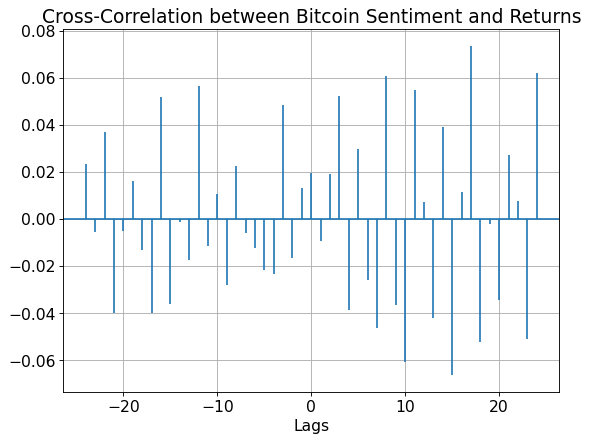

In [182]:
# cross-correlation plots

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Bitcoin Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_btc, ret_btc, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
 
plt.savefig('bitcoin_ccf_march.png', transparent=True)
plt.show() 

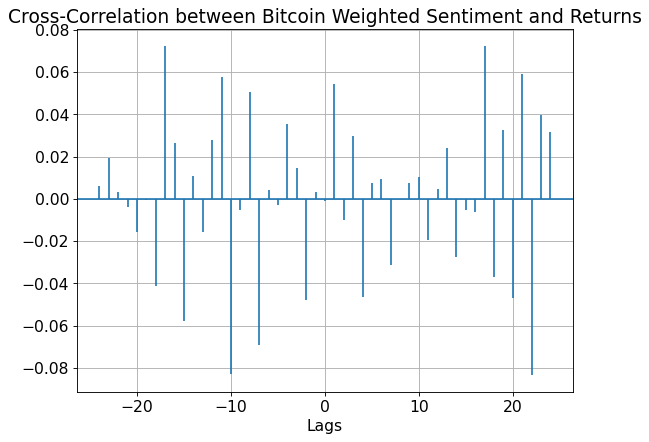

In [181]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Bitcoin Weighted Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(wsent_diff_btc, ret_btc, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)

plt.savefig('bitcoin_w_ccf_march.png', transparent=True)
plt.show() 

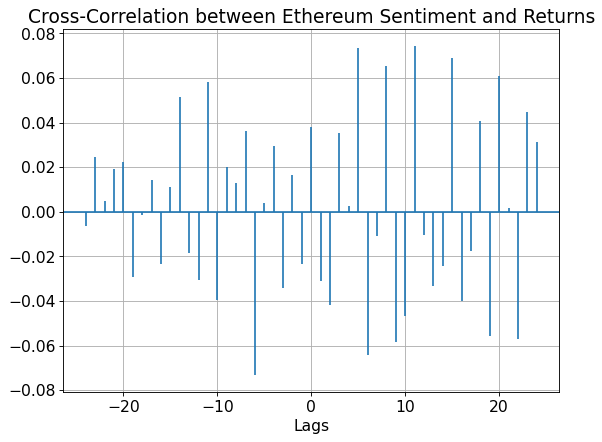

In [170]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Ethereum Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_eth, ret_eth, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
  
plt.show() 

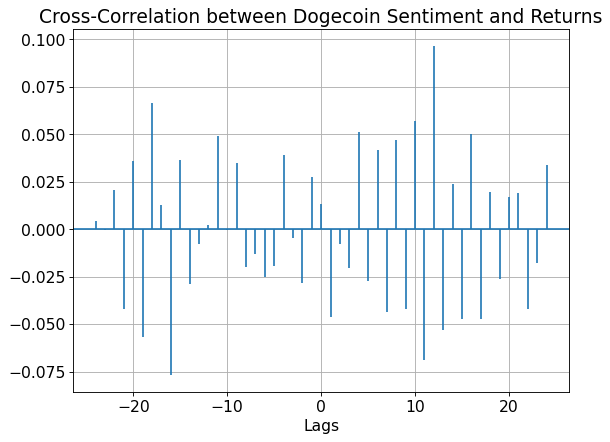

In [171]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Dogecoin Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_doge, ret_doge, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
  
plt.show() 

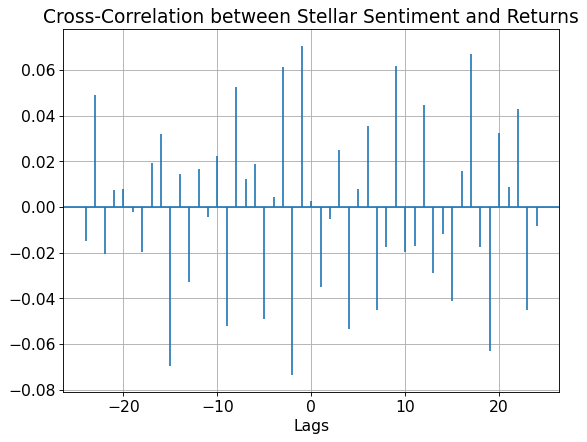

In [172]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Stellar Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_stellar, ret_stellar, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
  
plt.show() 

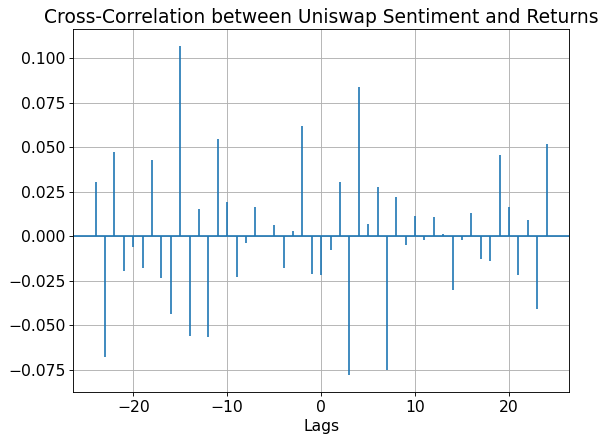

In [173]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Uniswap Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_uniswap, ret_uniswap, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
  
plt.show() 

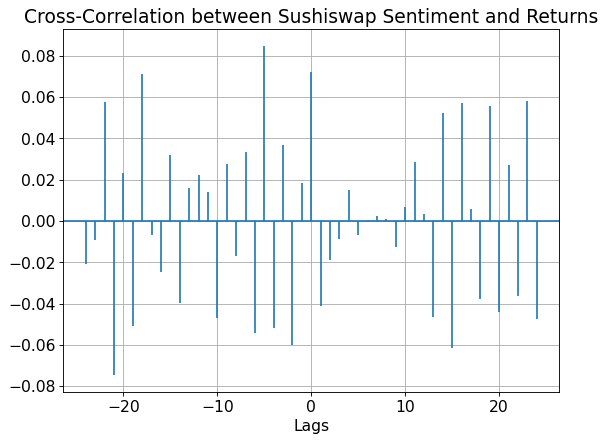

In [174]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title("Cross-Correlation between Sushiswap Sentiment and Returns")
  
# Providing x-axis name.
plt.xlabel("Lags")
  
# Plotting the Autocorreleation plot.
plt.xcorr(sent_diff_sushiswap, ret_sushiswap, maxlags = 24) 
  
# Displaying the plot.
plt.grid(True)
  
plt.show() 

In [163]:
ccf_eth.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
-6,-0.074110,-0.006929
6,-0.064363,-0.028674
9,-0.058799,-0.048683
22,-0.057679,0.002558
19,-0.056323,-0.047013
10,-0.047000,-0.010303
2,-0.041738,0.009631
-10,-0.040374,0.014632
16,-0.040296,-0.006079
-3,-0.034597,-0.047474


In [162]:
ccf_btc.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
15,-0.067391,-0.005391
10,-0.061323,0.010478
18,-0.053171,-0.037784
23,-0.052122,0.040633
7,-0.046945,-0.031574
13,-0.042675,0.024614
-21,-0.041369,-0.004126
-17,-0.041261,0.074585
4,-0.038866,-0.046821
-15,-0.037153,-0.059922


In [164]:
ccf_doge.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
-16,-0.080717,-0.009049
11,-0.069658,-0.028082
-19,-0.060105,0.009566
13,-0.053950,0.040146
17,-0.048405,-0.025222
15,-0.048160,0.024393
1,-0.046237,-0.052953
-21,-0.044500,0.031872
7,-0.043879,-0.043499
22,-0.042700,-0.030189


In [165]:
ccf_stellar.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
-15,-0.074642,-0.053325
-2,-0.073688,-0.051824
19,-0.064736,-0.027202
4,-0.053655,-0.048704
-9,-0.053120,-0.020533
-5,-0.049617,-0.030732
23,-0.046088,-0.051497
7,-0.045172,-0.088950
15,-0.041943,-0.019977
1,-0.034927,-0.011174


In [166]:
ccf_uniswap.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
3,-0.078952,-0.065793
7,-0.076631,-0.035493
-23,-0.070941,-0.078191
-12,-0.057679,-0.083401
-14,-0.057634,-0.005128
-16,-0.045323,-0.059194
23,-0.041980,-0.057564
25,-0.032444,-0.036311
14,-0.030775,0.021731
-17,-0.024574,-0.003647


In [167]:
ccf_sushiswap.sort_values(by='CC with Sentiment')

,CC with Sentiment,CC with Weighted Sentiment
-21,-0.078161,-0.073316
15,-0.062101,-0.062294
-2,-0.060232,-0.055153
-6,-0.055650,-0.063568
-19,-0.053234,-0.063880
-4,-0.053065,-0.050787
-10,-0.048230,-0.065712
24,-0.048110,-0.019202
13,-0.047095,-0.051205
20,-0.044719,-0.055893


## Epilogue: Prices of cryptocurrencies

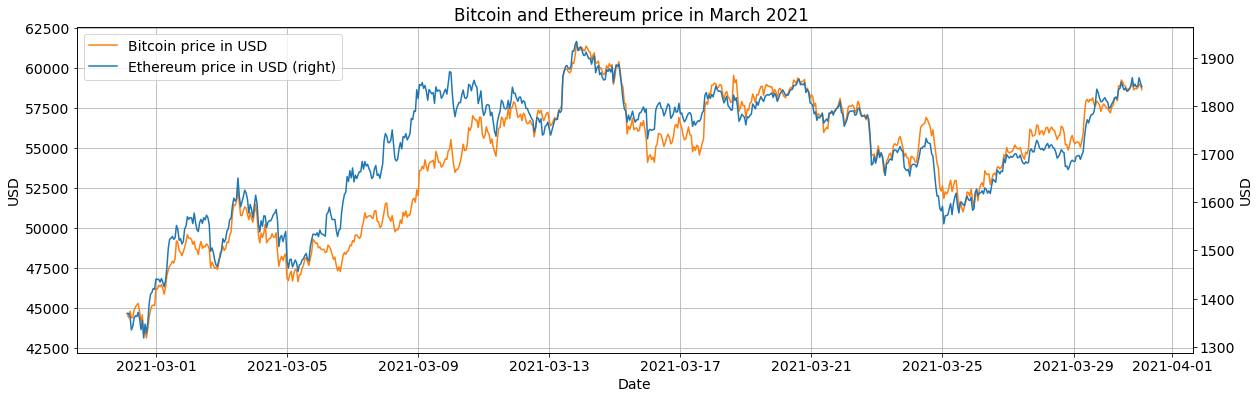

In [183]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(bitcoin_hour['datetime'], bitcoin_hour['Cryptocurrency price in USD'], color='tab:orange', label='Bitcoin price in USD')
lns2 = ax2.plot(eth_hour['datetime'], eth_hour['Cryptocurrency price in USD'], color='tab:blue', label='Ethereum price in USD (right)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Bitcoin and Ethereum price in March 2021 ')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('USD')
ax.grid(True)
ax.legend(lns, labs, loc='upper left')
plt.savefig('btc_and_eth.png', transparent=True)

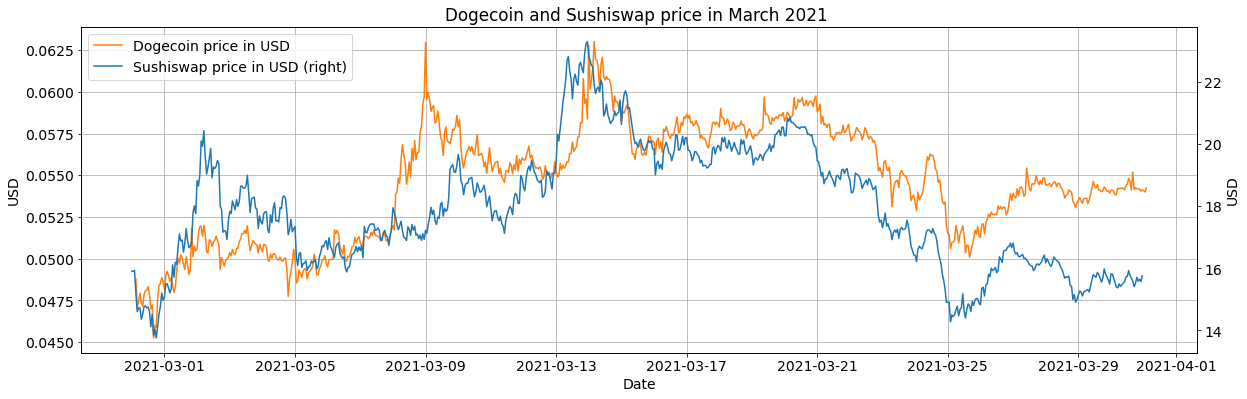

In [184]:
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(20,6))



ax2 = ax.twinx()
lns1 = ax.plot(doge_hour['datetime'], doge_hour['Cryptocurrency price in USD'], color='tab:orange', label='Dogecoin price in USD')
lns2 = ax2.plot(sushiswap_hour['datetime'], sushiswap_hour['Cryptocurrency price in USD'], color='tab:blue', label='Sushiswap price in USD (right)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]



ax.set_title('Dogecoin and Sushiswap price in March 2021 ')
ax.set_xlabel('Date')
ax.set_ylabel('USD')
ax2.set_ylabel('USD')
ax.grid(True)
ax.legend(lns, labs, loc='upper left')

plt.savefig('doge_and_sushi.png', transparent=True)